In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.measure import label, regionprops

/Users/kuanlin/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Load in the image

In [2]:
sender_image = plt.imread("./Sample_Data/Txn_series1_0min_sender.tif")
receiver_image = plt.imread("./Sample_Data/Txn_series1_0min_receiver.tif")

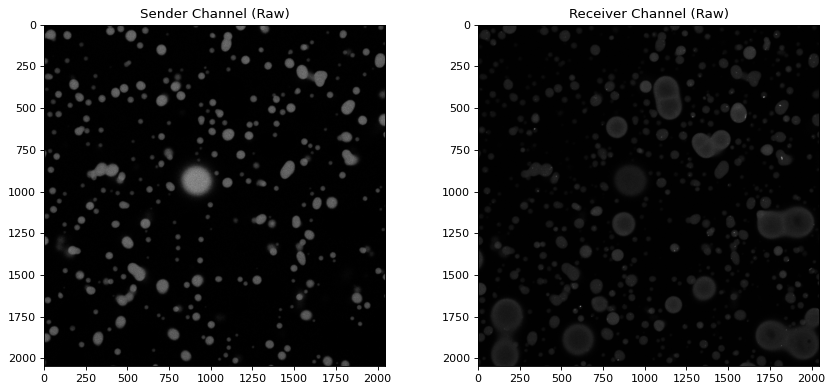

In [3]:
fig = plt.figure(figsize=(11, 5), dpi = 80)

plt.subplot(1, 2, 1)
plt.title("Sender Channel (Raw)")
plt.imshow(sender_image, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Receiver Channel (Raw)")
plt.imshow(receiver_image, cmap="gray")

plt.tight_layout()
plt.show()

### Sender Receiver Droplet Identification

In [4]:
def droplet_detection(sender_image, receiver_image):
    """
    Identify the locations of the sender and receiver droplets.
    """
    # Create Binary for better signal to noise
    binary = sender_image > (sender_image.mean() + sender_image.std())

    # use labeling function to identify connected blobs
    label_im = label(binary)
    blob_lists = regionprops(label_im)

    # Remove small blobs
    senders = [i for i in blob_lists if i.area > 500]
    
    # Mask to document all sender locations
    mask = np.zeros_like(binary)
    for i in senders:
        minr, minc, maxr, maxc = i.bbox
        mask[minr:maxr, minc:maxc] = 1
        
    # Create Binary for better signal to noise
    binary = receiver_image > (receiver_image.mean() + receiver_image.std())
    
    # use labeling function to identify connected blobs
    label_im = label(binary)
    blob_lists = regionprops(label_im)

    # Remove small blobs
    receivers = [i for i in blob_lists if i.area > 500]

    # Extract receiver droplets
    true_receivers = []
    for i in receivers:
        minr, minc, maxr, maxc = i.bbox
        if mask[int((minr+maxr)/2), int((minc+maxc)/2)] == 0:
            true_receivers.append(i)
            
    return senders, true_receivers

In [5]:
senders, receivers = droplet_detection(sender_image, receiver_image)

In [22]:
def droplet_value_extraction(droplets, image, filename = False, threshold = .75):
    """
    Extract the intensity value of the droplets. Can save as a txt file for later plotting.
    """
    
    values = []
    
    for blob in droplets:
        
        minr, minc, maxr, maxc = blob.bbox
        blob_img = image[minr:maxr, minc:maxc]
        vals = blob_img.flatten()
        background = np.quantile(image.flatten(), threshold)
        
        # Remove the background values
        vals = vals[vals > background]
        values.append(vals)
        
    values = np.concatenate(values)
    
    if filename: np.savetxt(filename, values, fmt='%f')
    
    return values

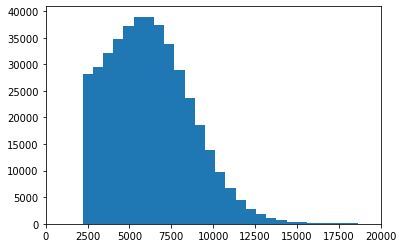

In [14]:
sender_values = droplet_value_extraction(senders, receiver_image, "./Sample_Data/sender_values.txt")

plt.hist(sender_values, bins = 100)
plt.xlim(0, 20000)
plt.show()

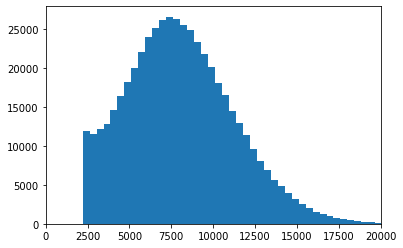

In [24]:
receiver_values = droplet_value_extraction(receivers, receiver_image, "./Sample_Data/receiver_values.txt",\
                                           threshold = .75)

plt.hist(receiver_values, bins = 100)
plt.xlim(0, 20000)
plt.show()